In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_149608/2647508162.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import templates
import fields
import spectrum

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generating templates of anisotropic shifts in $dN/dz$

We can generate a mock template providing the following inputs:
- `sigma_of_shift` = float. Standard deviation of the shifts across the template
- `nside` = int. Defines the pixelization
- `alpha` = float. Power law index for the perturbation Cls
- `lmax_pert` = int. lmax of the Cls

In [8]:
sigma_of_shift = 0.003
nside = 128
alpha = -2
lmax_pert = 100

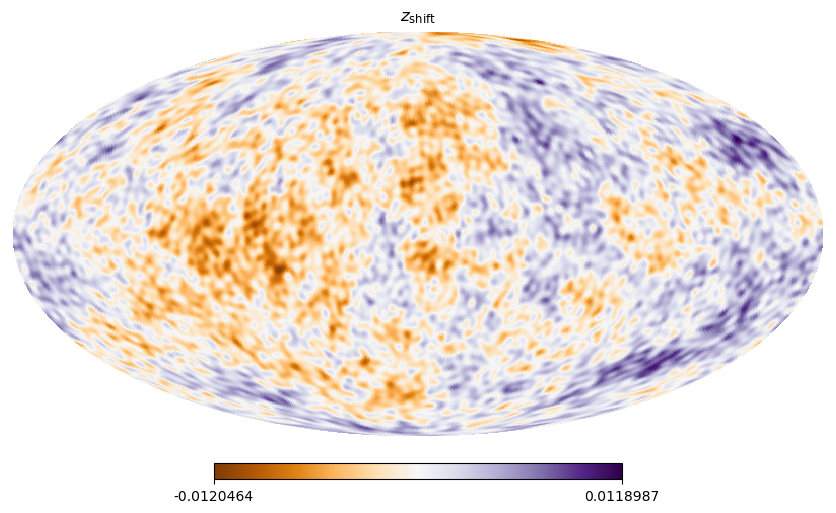

In [9]:
test_mock_template = templates.MockTemplate(sigma_of_shift, nside, alpha, lmax_pert)
test_mock_template.show()

Alternatively, if we already have a template characterizing the shifts in either the mean redshift or width of our $dN/dz$ in every pixel of some healpix pixelization, we can use the CustomTemplate class as follows:

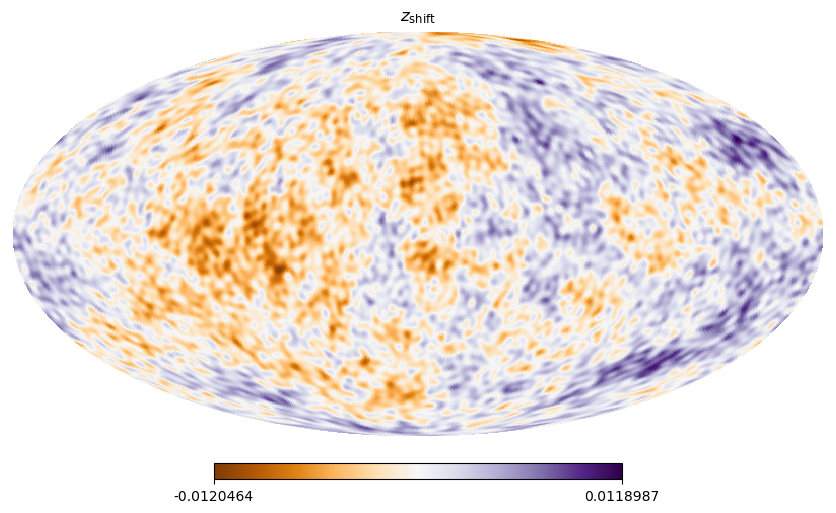

In [10]:
myshifts_template = test_mock_template.map

test_custom_template = templates.CustomTemplate(myshifts_template)
test_custom_template.show()

# Constructing `field` objects

We first need to introduce a `grid` object that will define the discrete redshifts we will be working with as well as the healpix pixelization (this will need to match our anisotropy templates)

In [11]:
n_samples_of_chi = 2**8 # (a power of 2). Number of samples in chi
sigma = 0.06 # Standard deviation of the fiducial dndz
z_mean = 0.59 # Central redshift of the fiducial dndz
z_max_int = z_mean + 10*sigma # Higher end of the integration range in redshift

my_grid = fields.grid(nside, n_samples_of_chi, z_max_int=z_max_int)

We'll now use one of the templates above to initialize objects corresponding to observed fields subject to projection anisotropy

In [12]:
#UNIT-redmagic bias parameters from 2101.11014
#         b1,    b2,    bs2,   bnabla2, SN
bvec = [0.786, 0.583, -0.406, -0.512, 1755]

gal_overdensity = fields.GalDelta(my_grid, sigma, z_mean, bvec, template_zmean_shifts=test_mock_template)

In [13]:
gal_kappa = fields.GalShear(my_grid, sigma, z_mean, template_zmean_shifts=test_mock_template)

Notice that these inherit the properties of the `Template` around which it is constructed, for example:

In [14]:
gal_overdensity.template_zmean_shifts.__dict__

{'lmax_pert': 100,
 'alpha': -2,
 'map': array([-0.00339121, -0.00409659, -0.00476965, ...,  0.0022887 ,
         0.00286434,  0.00377106]),
 'npix': 196608,
 'nside': 128,
 'sigma_of_shift': 0.003}

# Define a `Spec` object

In [15]:
cs_auto = spectrum.Spec(gal_kappa)
gc_auto = spectrum.Spec(gal_overdensity)
gc_x_cs = spectrum.Spec(gal_kappa, gal_overdensity)

These already have some interesting properties. For example, the covariance in each redshift slice will let us predict the biases on small angular scales

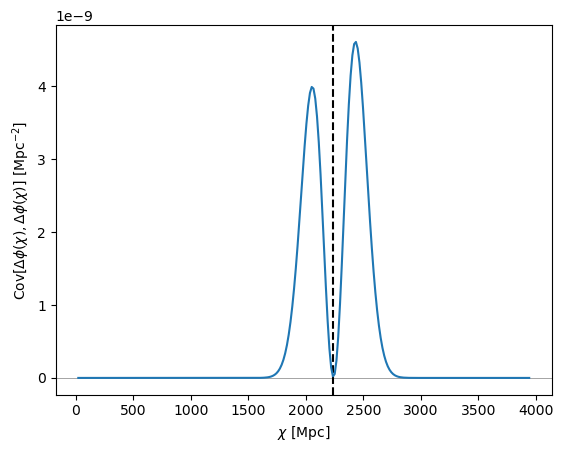

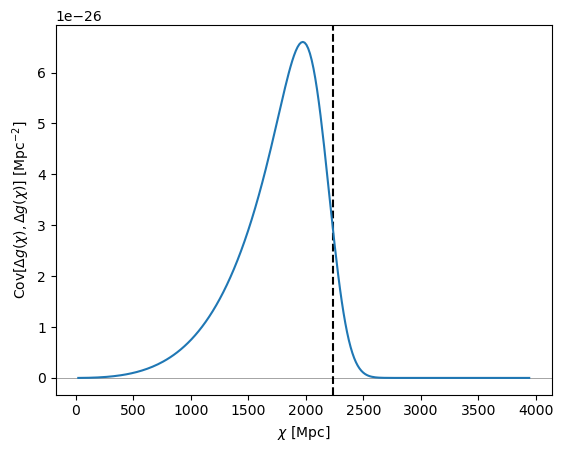

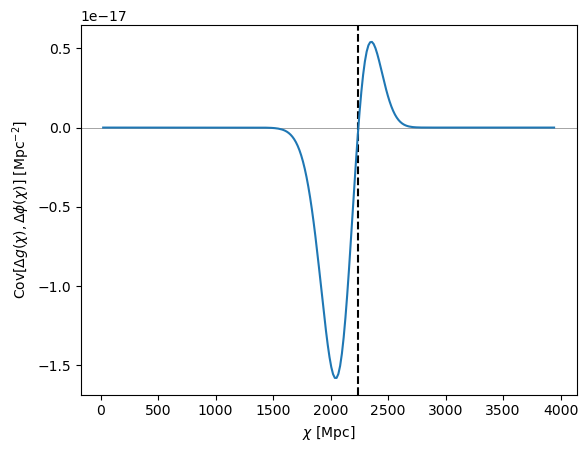

In [16]:
gc_auto.plot_DeltaP_covariance()
cs_auto.plot_DeltaP_covariance()
gc_x_cs.plot_DeltaP_covariance()

These objects also contain the fiducial projection kernels

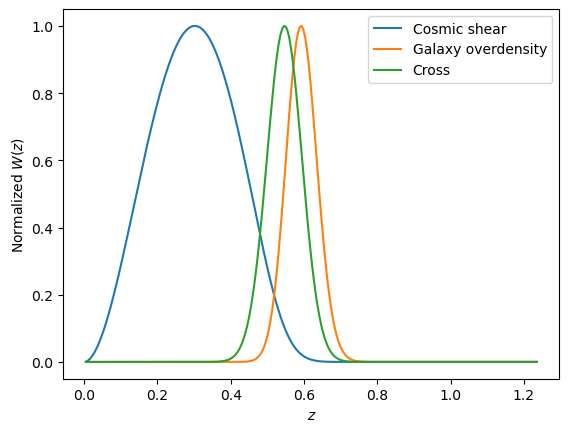

In [17]:
plt.plot(my_grid.z_array[0,:], cs_auto.kernel(my_grid.chi_array) / np.max(cs_auto.kernel(my_grid.chi_array)), label=r'Cosmic shear')
plt.plot(my_grid.z_array[0,:], gc_auto.kernel(my_grid.chi_array) / np.max(gc_auto.kernel(my_grid.chi_array)), label=r'Galaxy overdensity')
plt.plot(my_grid.z_array[0,:], gc_x_cs.kernel(my_grid.chi_array) / np.max(gc_x_cs.kernel(my_grid.chi_array)), label=r'Cross')

plt.xlabel(r'$z$')
plt.ylabel(r'Normalized $W(z)$')
plt.legend()

To compute the crucial quantity, $C_{\ell}^{\Delta x \Delta y}(\chi)$ (where $x$ and $y$ can be $\phi$ or $g$) we just call

In [18]:
gc_auto.get_Cldp1dp2()

`gc_auto` now has an attribute `gc_auto.Cl_deltap_of_chi1_chi2` that will get used when evaluating the biases. We can already inspect it:

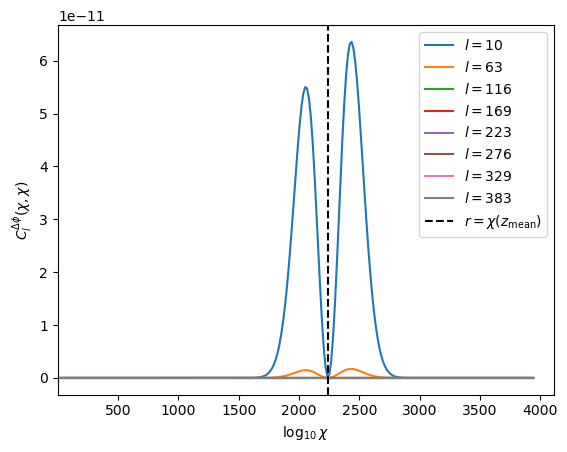

In [19]:
gc_auto.plot_Cl_DeltaP_of_chi()

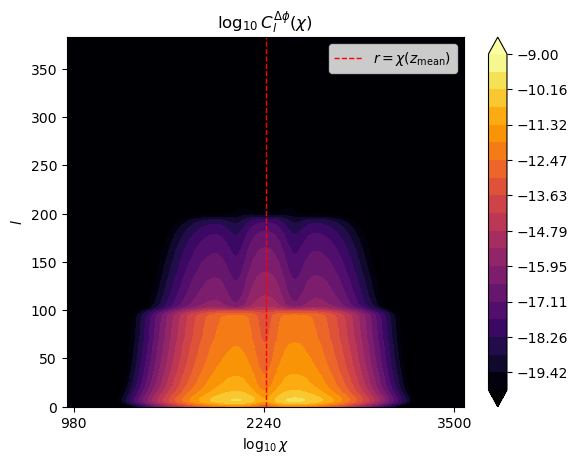

In [20]:
gc_auto.plot_Cl_DeltaP_of_chi_2D()

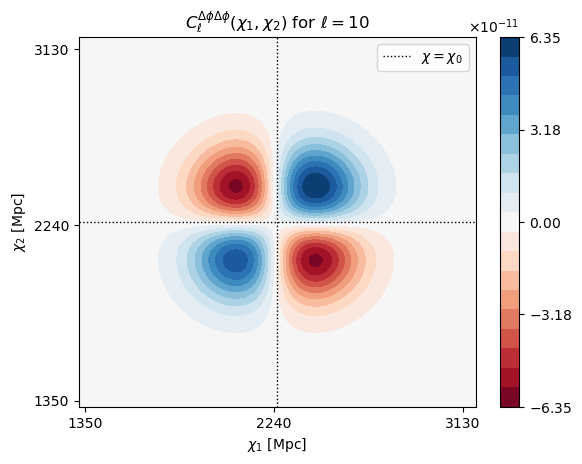

In [21]:
l = 10

gc_auto.plot_Cl_DeltaP_vs_chi_chiprime_2D(l)

### Calculating old and new contributions

More importantly, we're now in a position to calculate all contributions to angular clustering

In [43]:
gc_auto.get_contributions()

Working on l=49
Working on l=53
Working on l=57
Working on l=62
Working on l=66
Working on l=71
Working on l=77
Working on l=82
Working on l=89
Working on l=95
Working on l=103
Working on l=110
Working on l=119
Working on l=128
Working on l=137
Working on l=148
Working on l=159
Working on l=171
Working on l=183
Working on l=197
Working on l=212
Working on l=228
Working on l=245
Working on l=264
Working on l=283
Working on l=305
Working on l=328
Working on l=352
Working on l=379
Working on l=407
Working on l=438
Working on l=471
Working on l=506
Working on l=544
Working on l=585
Working on l=629
Working on l=676
Working on l=727
Working on l=782
Working on l=840
Working on l=903
Working on l=971
Working on l=1044
Working on l=1122
Working on l=1207
Working on l=1297
Working on l=1395
Working on l=1500
Using mode full
Working on l=49
Working on l=53
Working on l=57
Working on l=62
Working on l=66
Working on l=71
Working on l=77
Working on l=82
Working on l=89
Working on l=95
Working on l

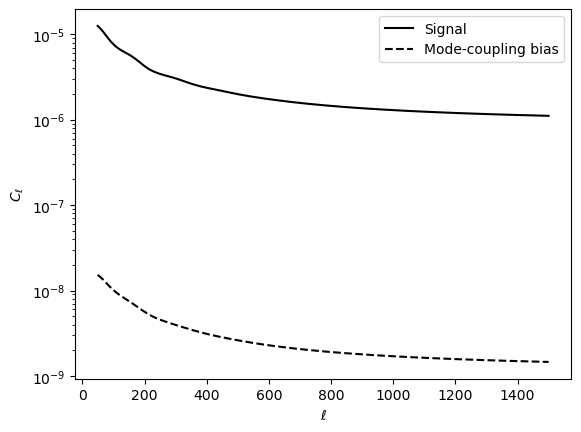

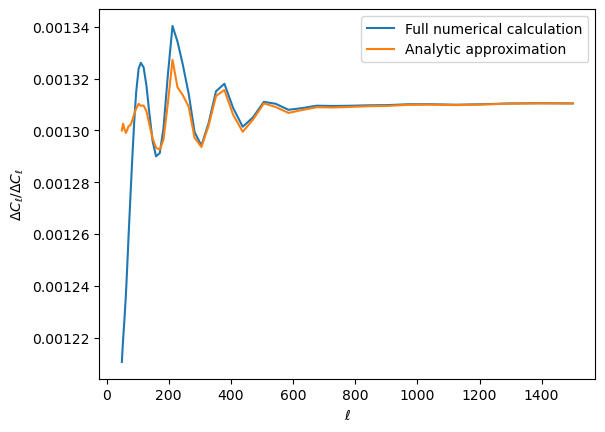

In [55]:
plt.semilogy(gc_auto.ells, gc_auto.unbiased_cls, color='k', label=r'Signal')
plt.semilogy(gc_auto.ells, gc_auto.conv_bias, ls='--', color='k', label=r'Mode-coupling bias')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.show()

plt.plot(gc_auto.ells, gc_auto.conv_bias/gc_auto.unbiased_cls, label=r'Full numerical calculation')
plt.plot(gc_auto.ells, gc_auto.analytic_mcbias_via_variance/gc_auto.unbiased_cls, label=r'Analytic approximation')
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta C_\ell / \Delta C_\ell$')
plt.show()

The second plot shows that the very simple analytic expression we developed in the paper is an excellent approximation!

Finally, note that we can save the object we've computed to file and retrieve it later:

In [66]:
# Save to file
gc_auto.save_properties(output_filename='dict_with_properties')

# Load from file
loaded_object = spectrum.Spec(load=True, filename='dict_with_properties')